In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os 
import glob
import cv2
import numpy as np

In [2]:
import sys
import platform

print("Python version: {}".format(sys.version))
print("{}".format(platform.platform()))

Python version: 3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
Linux-5.10.147+-x86_64-with-glibc2.29


In [3]:
imagesize=256
batchsize = 32
epochs=15

In [4]:
img_directory=""
mask_directory=""
num_img=999

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Image Preprocessing**

In [6]:
image_names=glob.glob("/content/drive/MyDrive/ImageCLF/data/training_set/training_set/*_*HC.png")

image_names.sort()

print(len(image_names))
image_names_subset=image_names[0:num_img]
images=[cv2.imread(img,0) for img in image_names_subset]
images=[cv2.resize(img,(256,256)) for img in images]
image_dataset=np.array(images)
print(image_dataset.shape)
image_dataset=np.expand_dims(image_dataset, axis=3)

999
(999, 256, 256)


In [7]:
mask_names=glob.glob("/content/drive/MyDrive/ImageCLF/data/training_set/Masks/*.png")

mask_names.sort()
mask_names_subset=mask_names[0:num_img]
masks=[cv2.imread(mask,0) for mask in mask_names_subset]
masks=[cv2.resize(mask,(256,256)) for mask in masks]
mask_dataset=np.array(masks)
mask_dataset=np.expand_dims(mask_dataset, axis=3)
print(mask_dataset.shape)

(999, 256, 256, 1)


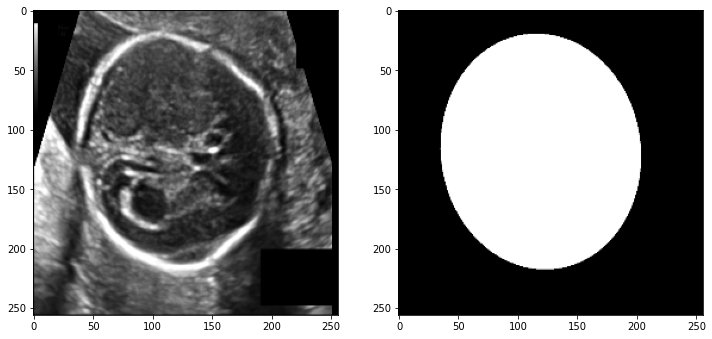

In [8]:
import random
image_number=random.randint(0,len(image_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image_dataset[image_number,:,:,0],cmap='gray')
plt.subplot(122)
plt.imshow(mask_dataset[image_number,:,:,0], cmap="gray")
plt.show()

In [9]:
from skimage.segmentation import clear_border

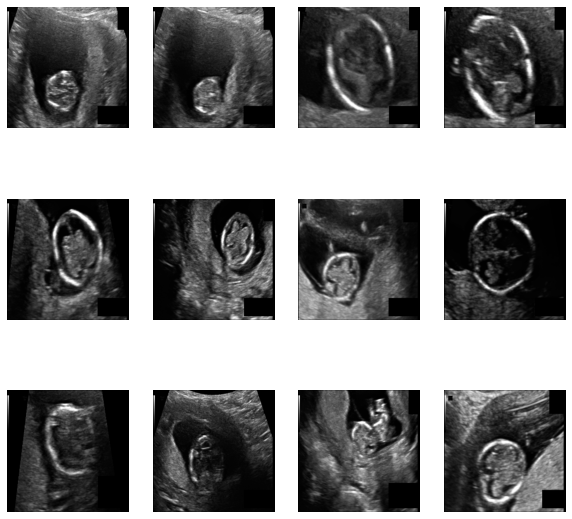

In [10]:
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_dataset[i,:,:,0], cmap='gray')
    plt.axis('off')

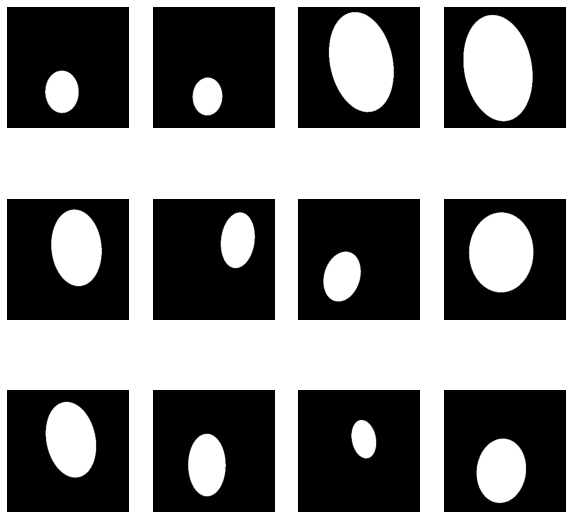

In [11]:
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(mask_dataset[i,:,:,0], cmap='gray')
    plt.axis('off')

In [12]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('/content/drive/MyDrive/ImageCLF/data/test_set/test_set/*.png'): 
    im=Image.open(filename)
    image_list.append(im)

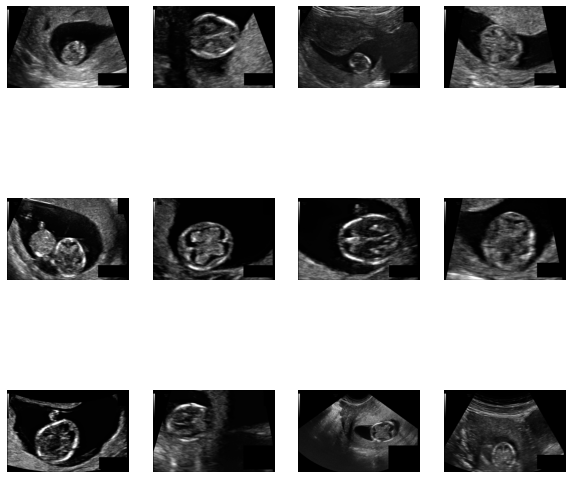

In [13]:
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_list[i], cmap='gray')
    plt.axis('off')

In [14]:
image_dataset=image_dataset/256
mask_dataset=mask_dataset/256

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_dataset,mask_dataset, test_size=.2, random_state=42)

In [16]:
f'x_train : {x_train.shape} - x_test : {x_test.shape}'

'x_train : (799, 256, 256, 1) - x_test : (200, 256, 256, 1)'

In [17]:
f'y_train : {y_train.shape} - y_test : {y_test.shape}'

'y_train : (799, 256, 256, 1) - y_test : (200, 256, 256, 1)'

In [18]:
Img_height=image_dataset.shape[1]
Img_width=image_dataset.shape[2]
Img_channel=image_dataset.shape[3]
input_shape=(Img_height,Img_width,Img_channel)
f'height : {Img_height} , width : {Img_width}, channel : {Img_channel}, shape : {input_shape}'

'height : 256 , width : 256, channel : 1, shape : (256, 256, 1)'

# **U-Net Model**

In [19]:
import tensorflow as tf
import zipfile
import numpy as np
import random
import os
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [55]:
input_shape=(Img_height,Img_width,Img_channel)
inputs = tf.keras.layers.Input(input_shape)
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs) # normalization

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(s) # start with normal distributed weights
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = "same")(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u6)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = "same")(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u7)
c7 = tf.keras.layers.Dropout(0.1)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = "same")(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = "same")(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 256, 256, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  160         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

In [56]:
# Callbacks
checkpoiter = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)
callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'),tf.keras.callbacks.TensorBoard(log_dir = 'logs')]

In [ ]:
results = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_test,y_test),
    batch_size = 32, 
    epochs = 50, 
    callbacks = callbacks)

In [ ]:
idx = random.randint(0, len(x_train))

preds_train = model.predict(x_train[:int(x_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(x_train[int(x_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(x_test, verbose = 1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# **Accuracy Metrics**

In [61]:
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, jaccard_score

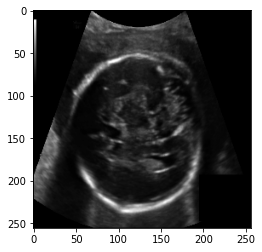

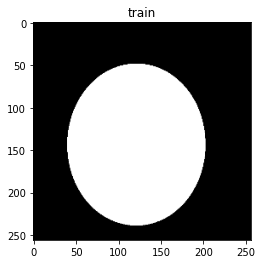

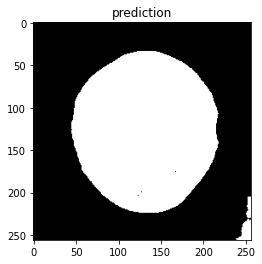

In [69]:
# Sanity check on random training samples
ix = random.randint(0, len(preds_train_t))
plt.imshow(x_test[ix,:,:,0], cmap='gray')
plt.show()
plt.imshow(np.squeeze(y_test[ix,:,:,0]), cmap='gray')
plt.title('train')
plt.show()
plt.imshow(np.squeeze(preds_train_t[ix,:,:,0]), cmap='gray')
plt.title(f'prediction')
plt.show()

In [63]:
test_image=glob.glob("/content/drive/MyDrive/ImageCLF/data/test_set/test_set/*_HC.png")

test_image.sort()

print(len(test_image))
test_image_subset=test_image[0:num_img]
images=[cv2.imread(img,0) for img in test_image_subset]
images=[cv2.resize(img,(256,256)) for img in images]
test_dataset=np.array(images)
print(test_dataset.shape)
test_dataset=np.expand_dims(test_dataset, axis=3)

268
(268, 256, 256)


In [64]:
# Predictions
idx = random.randint(0, len(test_dataset))

preds_train = model.predict(test_dataset[:int(test_dataset.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(test_dataset[int(test_dataset.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(test_dataset, verbose = 1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

9/9 [==============================] - 1s 76ms/step


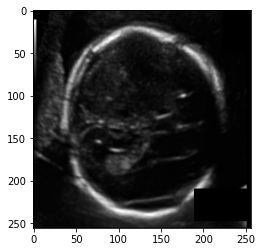

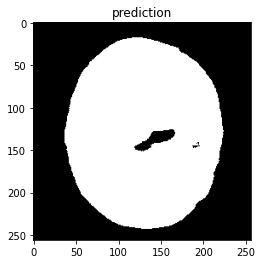

In [66]:
# Sanity check on random training samples
ix = random.randint(0, len(preds_train_t))
plt.imshow(test_dataset[ix,:,:,0], cmap='gray')
plt.show()
plt.imshow(np.squeeze(preds_train_t[ix,:,:,0]), cmap='gray')
plt.title(f'prediction')
plt.show()